In [1]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import numpy as np
import time
import os
import copy
from torch.utils.data import DataLoader, Dataset
import torch.utils.data as utils
from torchvision import transforms

import warnings
warnings.filterwarnings("ignore")

In [2]:
# Applying Transforms to the Data
image_transforms = { 
    'train': transforms.Compose([
        transforms.RandomResizedCrop(size=256, scale=(0.8, 1.0)),
        transforms.RandomRotation(degrees=15),
        transforms.RandomHorizontalFlip(),
        transforms.CenterCrop(size=224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ]),
   
    'test': transforms.Compose([
        transforms.Resize(size=256),
        transforms.CenterCrop(size=224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ])
}

In [3]:
dataset = 'caltech_10'
data_dir = r"C:\Users\Rekha\Documents\pytorch_image_classification"
train_dir = r"C:\Users\Rekha\Documents\pytorch_image_classification\Train"
test_dir = r"C:\Users\Rekha\Documents\pytorch_image_classification\Test"
#batch Size
bs =64

# Number of classes
num_classes = len(os.listdir(train_dir))  #10#2#257
print(num_classes)

43


In [4]:
data = {
    'train': datasets.ImageFolder(root=train_dir, transform=image_transforms['train']),
    'test': datasets.ImageFolder(root=test_dir, transform=image_transforms['test'])
}

# Get a mapping of the indices to the class names, in order to see the output classes of the test images.
idx_to_class = {v: k for k, v in data['train'].class_to_idx.items()}
print(idx_to_class)

# Size of Data, to be used for calculating Average Loss and Accuracy
train_data_size = len(data['train'])
#valid_data_size = len(data['valid'])
test_data_size = len(data['test'])

# Create iterators for the Data loaded using DataLoader module
train_data_loader = DataLoader(data['train'], batch_size=bs, shuffle=True)
#valid_data_loader = DataLoader(data['valid'], batch_size=bs, shuffle=True)
test_data_loader = DataLoader(data['test'], batch_size=bs, shuffle=True)

{0: 'Ahead only', 1: 'Beware of ice or snow', 2: 'Bicycles crossing', 3: 'Bumpy road', 4: 'Children crossing', 5: 'Dangerous curve left', 6: 'Dangerous curve right', 7: 'Double curve', 8: 'End no passing veh  3.5 tons', 9: 'End of no passing', 10: 'End of speed limit (80kmh)', 11: 'End speed + passing limits', 12: 'General caution', 13: 'Go straight or left', 14: 'Go straight or right', 15: 'Keep left', 16: 'Keep right', 17: 'No entry', 18: 'No passing', 19: 'No passing veh over 3.5 tons', 20: 'No vehicles', 21: 'Pedestrians', 22: 'Priority road', 23: 'Right-of-way at intersection', 24: 'Road narrows on the right', 25: 'Road work', 26: 'Roundabout mandatory', 27: 'Slippery road', 28: 'Speed limit (100kmh)', 29: 'Speed limit (120kmh)', 30: 'Speed limit (20kmh)', 31: 'Speed limit (30kmh)', 32: 'Speed limit (50kmh', 33: 'Speed limit (60kmh)', 34: 'Speed limit (70kmh)', 35: 'Speed limit (80kmh)', 36: 'Stop', 37: 'Traffic signals', 38: 'Turn left ahead', 39: 'Turn right ahead', 40: 'Veh  3.

In [5]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(train_data_size,test_data_size)

39209 11422


In [6]:
# Load pretrained ResNet50 Model
resnet50 = models.resnet50(pretrained=True)
resnet50 = resnet50.to(device)

In [7]:
# Freeze model parameters
for param in resnet50.parameters():
    param.requires_grad = False

In [8]:
# Change the final layer of ResNet50 Model for Transfer Learning
fc_inputs = resnet50.fc.in_features

resnet50.fc = nn.Sequential(
    nn.Linear(fc_inputs, 256),
    nn.ReLU(),
    nn.Dropout(0.4),
    nn.Linear(256, num_classes), # Since 10 possible outputs
    nn.LogSoftmax(dim=1) # For using NLLLoss()
)



# Convert model to be used on GPU
resnet50 = resnet50.to(device)

In [9]:
# Define Optimizer and Loss Function
loss_func = nn.NLLLoss()
optimizer = optim.Adam(resnet50.parameters())

In [10]:
def train_and_test(model, loss_criterion, optimizer, epochs=25):
    '''
    Function to train and validate
    Parameters
        :param model: Model to train and test
        :param loss_criterion: Loss Criterion to minimize
        :param optimizer: Optimizer for computing gradients
        :param epochs: Number of epochs (default=25)
  
    Returns
        model: Trained Model with best test accuracy
        history: (dict object): Having training loss, accuracy and test loss, accuracy
    '''
    
    start = time.time()
    history = []
    best_loss = 100000.0
    best_epoch = None

    for epoch in range(epochs):
        epoch_start = time.time()
        print("Epoch: {}/{}".format(epoch+1, epochs))
        
        # Set to training mode
        model.train()
        
        # Loss and Accuracy within the epoch
        train_loss = 0.0
        train_acc = 0.0
        
        test_loss = 0.0
        test_acc = 0.0
        
        for i, (inputs, labels) in enumerate(train_data_loader):

            inputs = inputs.to(device)
            labels = labels.to(device)
            
            # Clean existing gradients
            optimizer.zero_grad()
            
            # Forward pass - compute outputs on input data using the model
            outputs = model(inputs)
            
            # Compute loss
            loss = loss_criterion(outputs, labels)
            
            # Backpropagate the gradients
            loss.backward()
            
            # Update the parameters
            optimizer.step()
            
            # Compute the total loss for the batch and add it to train_loss
            train_loss += loss.item() * inputs.size(0)
            
            # Compute the accuracy
            ret, predictions = torch.max(outputs.data, 1)
            correct_counts = predictions.eq(labels.data.view_as(predictions))
            
            # Convert correct_counts to float and then compute the mean
            acc = torch.mean(correct_counts.type(torch.FloatTensor))
            
            # Compute total accuracy in the whole batch and add to train_acc
            train_acc += acc.item() * inputs.size(0)
            
            #print("Batch number: {:03d}, Training: Loss: {:.4f}, Accuracy: {:.4f}".format(i, loss.item(), acc.item()))

        
        # test - No gradient tracking needed
        with torch.no_grad():

            # Set to evaluation mode
            model.eval()

            # Validation loop
            for j, (inputs, labels) in enumerate(test_data_loader):
                inputs = inputs.to(device)
                labels = labels.to(device)

                # Forward pass - compute outputs on input data using the model
                outputs = model(inputs)

                # Compute loss
                loss = loss_criterion(outputs, labels)

                # Compute the total loss for the batch and add it to valid_loss
                test_loss += loss.item() * inputs.size(0)

                # Calculate validation accuracy
                ret, predictions = torch.max(outputs.data, 1)
                correct_counts = predictions.eq(labels.data.view_as(predictions))

                # Convert correct_counts to float and then compute the mean
                acc = torch.mean(correct_counts.type(torch.FloatTensor))

                # Compute total accuracy in the whole batch and add to valid_acc
                test_acc += acc.item() * inputs.size(0)

                #print("Validation Batch number: {:03d}, Validation: Loss: {:.4f}, Accuracy: {:.4f}".format(j, loss.item(), acc.item()))
        if test_loss < best_loss:
            best_loss = test_loss
            best_epoch = epoch

        # Find average training loss and training accuracy
        avg_train_loss = train_loss/train_data_size 
        avg_train_acc = train_acc/train_data_size

        # Find average training loss and training accuracy
        avg_test_loss = test_loss/test_data_size 
        avg_test_acc = test_acc/test_data_size

        history.append([avg_train_loss, avg_test_loss, avg_train_acc, avg_test_acc])
                
        epoch_end = time.time()
    
        print("Epoch : {:03d}, Training: Loss - {:.4f}, Accuracy - {:.4f}%, \n\t\test : Loss - {:.4f}, Accuracy - {:.4f}%, Time: {:.4f}s".format(epoch, avg_train_loss, avg_train_acc*100, avg_test_loss, avg_test_acc*100, epoch_end-epoch_start))
        
        # Save if the model has best accuracy till now
        torch.save(model, dataset+'_model_'+str(epoch)+'.pt')
            
    return model, history, best_epoch

In [11]:
# Print the model to be trained
#summary(resnet50, input_size=(3, 224, 224), batch_size=bs, device='cuda')

# Train the model for 25 epochs
num_epochs = 25
trained_model, history, best_epoch = train_and_test(resnet50, loss_func, optimizer, num_epochs)

torch.save(history, dataset+'_history.pt')

Epoch: 1/25
Epoch : 000, Training: Loss - 1.8566, Accuracy - 43.7604%, 
		est : Loss - 1.2254, Accuracy - 61.7843%, Time: 978.2344s
Epoch: 2/25
Epoch : 001, Training: Loss - 1.2997, Accuracy - 57.8235%, 
		est : Loss - 1.0234, Accuracy - 65.7766%, Time: 870.5692s
Epoch: 3/25
Epoch : 002, Training: Loss - 1.1757, Accuracy - 61.1594%, 
		est : Loss - 0.8820, Accuracy - 72.0014%, Time: 839.4128s
Epoch: 4/25
Epoch : 003, Training: Loss - 1.1020, Accuracy - 63.0570%, 
		est : Loss - 0.8611, Accuracy - 71.2397%, Time: 861.7472s
Epoch: 5/25
Epoch : 004, Training: Loss - 1.0541, Accuracy - 64.4367%, 
		est : Loss - 0.8096, Accuracy - 73.1833%, Time: 807.4999s
Epoch: 6/25
Epoch : 005, Training: Loss - 1.0235, Accuracy - 65.5538%, 
		est : Loss - 0.7309, Accuracy - 75.1532%, Time: 788.9033s
Epoch: 7/25
Epoch : 006, Training: Loss - 0.9907, Accuracy - 66.7347%, 
		est : Loss - 0.7469, Accuracy - 73.6911%, Time: 772.3749s
Epoch: 8/25
Epoch : 007, Training: Loss - 0.9723, Accuracy - 67.1019%, 
		es

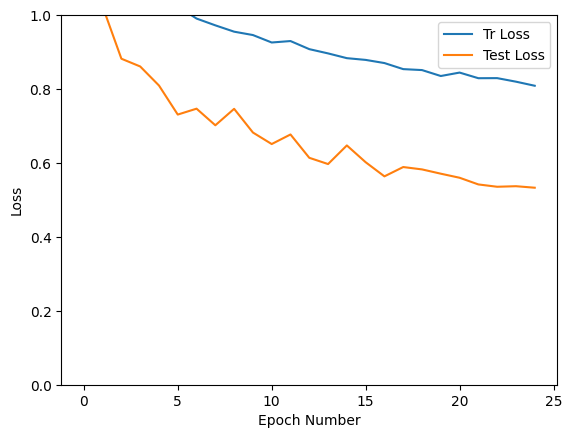

In [12]:
history = np.array(history)
plt.plot(history[:,0:2])
plt.legend(['Tr Loss', 'Test Loss'])
plt.xlabel('Epoch Number')
plt.ylabel('Loss')
plt.ylim(0,1)
plt.savefig(dataset+'_loss_curve.png')
plt.show()

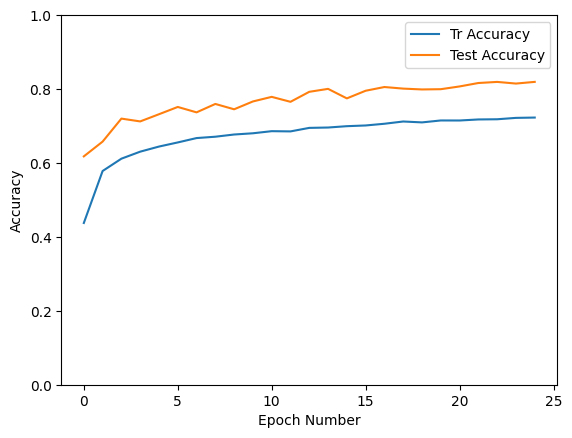

In [13]:
plt.plot(history[:,2:4])
plt.legend(['Tr Accuracy', 'Test Accuracy'])
plt.xlabel('Epoch Number')
plt.ylabel('Accuracy')
plt.ylim(0,1)
plt.savefig(dataset+'_accuracy_curve.png')
plt.show()

In [19]:
loss_criterion = nn.CrossEntropyLoss()

In [20]:
def computeTestSetAccuracy(model, loss_criterion):
    '''
    Function to compute the accuracy on the test set
    Parameters
        :param model: Model to test
        :param loss_criterion: Loss Criterion to minimize
    '''

    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    test_acc = 0.0
    test_loss = 0.0

    # Validation - No gradient tracking needed
    with torch.no_grad():

        # Set to evaluation mode
        model.eval()

        # Validation loop
        for j, (inputs, labels) in enumerate(test_data_loader):
            inputs = inputs.to(device)
            labels = labels.to(device)

            # Forward pass - compute outputs on input data using the model
            outputs = model(inputs)

            # Compute loss
            loss = loss_criterion(outputs, labels)

            # Compute the total loss for the batch and add it to valid_loss
            test_loss += loss.item() * inputs.size(0)

            # Calculate validation accuracy
            ret, predictions = torch.max(outputs.data, 1)
            correct_counts = predictions.eq(labels.data.view_as(predictions))

            # Convert correct_counts to float and then compute the mean
            acc = torch.mean(correct_counts.type(torch.FloatTensor))

            # Compute total accuracy in the whole batch and add to valid_acc
            test_acc += acc.item() * inputs.size(0)

            print("Test Batch number: {:03d}, Test: Loss: {:.4f}, Accuracy: {:.4f}".format(j, loss.item(), acc.item()))

    # Find average test loss and test accuracy
    avg_test_loss = test_loss/test_data_size 
    avg_test_acc = test_acc/test_data_size

    print("Test accuracy : " + str(avg_test_acc))

In [21]:
computeTestSetAccuracy(model, loss_criterion)

Test Batch number: 000, Test: Loss: 0.7341, Accuracy: 0.7969
Test Batch number: 001, Test: Loss: 0.6084, Accuracy: 0.8125
Test Batch number: 002, Test: Loss: 0.5696, Accuracy: 0.8125
Test Batch number: 003, Test: Loss: 0.5997, Accuracy: 0.7969
Test Batch number: 004, Test: Loss: 0.5095, Accuracy: 0.8594
Test Batch number: 005, Test: Loss: 0.5480, Accuracy: 0.7812
Test Batch number: 006, Test: Loss: 0.8543, Accuracy: 0.7500
Test Batch number: 007, Test: Loss: 0.4007, Accuracy: 0.8906
Test Batch number: 008, Test: Loss: 0.4971, Accuracy: 0.8125
Test Batch number: 009, Test: Loss: 0.5263, Accuracy: 0.8125
Test Batch number: 010, Test: Loss: 0.5716, Accuracy: 0.7812
Test Batch number: 011, Test: Loss: 0.5052, Accuracy: 0.7969
Test Batch number: 012, Test: Loss: 0.8004, Accuracy: 0.7031
Test Batch number: 013, Test: Loss: 0.4621, Accuracy: 0.8906
Test Batch number: 014, Test: Loss: 0.7586, Accuracy: 0.7031
Test Batch number: 015, Test: Loss: 0.5146, Accuracy: 0.7969
Test Batch number: 016, 

KeyboardInterrupt: 

In [23]:
from PIL import Image


In [24]:
def predict(model, test_image_name):
    '''
    Function to predict the class of a single test image
    Parameters
        :param model: Model to test
        :param test_image_name: Test image

    '''
    
    transform = image_transforms['test']


    test_image = Image.open(test_image_name)
    plt.imshow(test_image)
    
    test_image_tensor = transform(test_image)
    if torch.cuda.is_available():
        test_image_tensor = test_image_tensor.view(1, 3, 224, 224).cuda()
    else:
        test_image_tensor = test_image_tensor.view(1, 3, 224, 224)
    
    with torch.no_grad():
        model.eval()
        # Model outputs log probabilities
        out = model(test_image_tensor)
        ps = torch.exp(out)

        topk, topclass = ps.topk(3, dim=1)
        cls = idx_to_class[topclass.cpu().numpy()[0][0]]
        score = topk.cpu().numpy()[0][0]

        for i in range(3):
            print("Predcition", i+1, ":", idx_to_class[topclass.cpu().numpy()[0][i]], ", Score: ", topk.cpu().numpy()[0][i])

In [28]:
# Test a particular model on a test image

data_dir = r"C:\Users\Rekha\Documents\pytorch_image_classification"
model = torch.load("{}_model_{}.pt".format(dataset, best_epoch))
predict(model, r'C:\Users\Rekha\Documents\pytorch_image_classification\valid\1.png')

# Load Data from folders
#computeTestSetAccuracy(model, loss_func)
        
        

Predcition 1 : Road work , Score:  0.3301878
Predcition 2 : Bicycles crossing , Score:  0.3298232
Predcition 3 : Children crossing , Score:  0.25105184


In [29]:
data_dir = r"C:\Users\Rekha\Documents\pytorch_image_classification"
model = torch.load("{}_model_{}.pt".format(dataset, best_epoch))
predict(model, r'C:\Users\Rekha\Documents\pytorch_image_classification\valid\2.png')

Predcition 1 : No entry , Score:  0.9874379
Predcition 2 : No passing , Score:  0.012331276
Predcition 3 : End of no passing , Score:  0.00013190259


In [30]:
data_dir = r"C:\Users\Rekha\Documents\pytorch_image_classification"
model = torch.load("{}_model_{}.pt".format(dataset, best_epoch))
predict(model, r'C:\Users\Rekha\Documents\pytorch_image_classification\valid\3.png')

Predcition 1 : Keep right , Score:  0.55179536
Predcition 2 : Ahead only , Score:  0.17002669
Predcition 3 : Turn right ahead , Score:  0.14419585


In [31]:
data_dir = r"C:\Users\Rekha\Documents\pytorch_image_classification"
model = torch.load("{}_model_{}.pt".format(dataset, best_epoch))
predict(model, r'C:\Users\Rekha\Documents\pytorch_image_classification\valid\4.png')

Predcition 1 : Dangerous curve left , Score:  0.42160556
Predcition 2 : Bumpy road , Score:  0.15849832
Predcition 3 : General caution , Score:  0.11348948
